# Routes annotation with clustering

In [1]:
import json
import os
from typing import List
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

%matplotlib inline

from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.structures import BoxMode
from collections import defaultdict
from scipy.stats import kurtosis, skew

Extract images from dataset

In [2]:
hold_class_mapping = {"hold": 0, "volume": 1}


def create_dataset_dicts(
    img_dir: str, annotation_filename: str = "annotation.json"
) -> List[dict]:
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        img_annotations = json.load(f)["_via_img_metadata"]
    dataset = []
    for id, image in enumerate(img_annotations.values()):
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        if not all(
            [
                region["region_attributes"]["label_type"] == "handlabeled"
                for region in image["regions"]
            ]
        ):
            # Skip images which have regions that are not handlabeled
            continue
        record = {}
        image_filename = os.path.join(img_dir, image["filename"])
        height, width = cv2.imread(image_filename).shape[:2]

        # Create dataset dict according to detectron2 dataset specification
        # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts

        record["file_name"] = image_filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = id

        annotation_objects = []
        for region in image["regions"]:
            anno = region["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            # Merge point lists and flatten to [x_1, y_1, ..., x_n y_n] format
            polygons = [(x, y) for (x, y) in zip(px, py)]
            polygons = np.ravel(polygons).tolist()
            annotation_obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [polygons],
                "category_id": hold_class_mapping[
                    region["region_attributes"]["hold_type"]
                ],
            }
            annotation_objects.append(annotation_obj)
        record["annotations"] = annotation_objects
        dataset.append(record)
    return dataset

In [3]:
for dataset_type in ["test"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"../data/bh/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold"]
hold_metadata_test = MetadataCatalog.get("hold_test")

In [4]:
dataset_dicts = create_dataset_dicts("../data/bh/test")
d_dict = dataset_dicts[1]
image_bgr = cv2.imread(d_dict["file_name"])
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)  # TODO determine if this makes sense
# image = image_bgr

In [5]:
def plot_routes(routes: List, d_dict):
    image_bgr = cv2.imread(d_dict["file_name"])
    for k, holds in routes.items():
        height = d_dict["height"]
        width = d_dict["width"]
        final_bitmask = np.zeros((height, width))
        for hold_id in holds:
            hold_poly = d_dict["annotations"][hold_id]
            points = np.array(hold_poly["segmentation"])
            points = points.reshape((-1, 2)).astype(np.int32)
            points = points[np.newaxis, :]
            bitmask = cv2.fillPoly(np.zeros(image_bgr.shape[:2]), points, 255).astype(
                np.uint8
            )
            final_bitmask = final_bitmask + bitmask
        final_bitmask = final_bitmask.astype(np.bool8).astype(np.float32)
        img = image_bgr.transpose((2, 0, 1))
        masked_output = img * final_bitmask
        img_routes = masked_output.astype(np.int32).transpose((1, 2, 0))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(img_routes[:, :, ::-1])
        ax[1].imshow(image_bgr[:, :, ::-1])

# Color Moments

In [6]:
# Masked versions of color moments https://en.wikipedia.org/wiki/Color_moments
def masked_skewness(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return skew(image_raveled, axis=1)


def masked_kurtosis(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return kurtosis(image_raveled, axis=1)

In [7]:
color_moments = defaultdict(list)
for idx, poly in enumerate(d_dict["annotations"]):
    if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
        continue
    points = np.array(poly["segmentation"])
    points = points.reshape((-1, 2)).astype(np.int32)
    points = points[np.newaxis, :]
    mask = cv2.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
    mean_v, std_v = cv2.meanStdDev(image, mask=mask)
    # skew_v = masked_skewness(image, mask)
    # kurtosis_v = masked_kurtosis(image, mask)
    color_moments[idx].extend(mean_v[0:1, 0])
    color_moments[idx].extend(std_v[0:1, 0])
    # color_moments[idx].extend(skew_v[0:3])
    # color_moments[idx].extend(kurtosis_v[0:3])

In [8]:
color_moment_arr = np.array(list(color_moments.values()))
color_moments_arr_norm = color_moment_arr - np.mean(color_moment_arr, axis=0)
color_moments_arr_norm = color_moments_arr_norm / np.std(color_moments_arr_norm, axis=0)

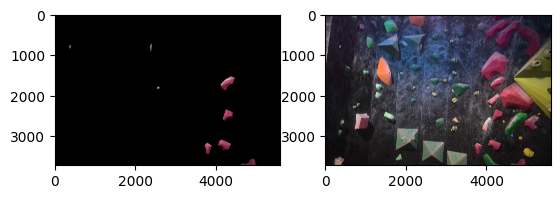

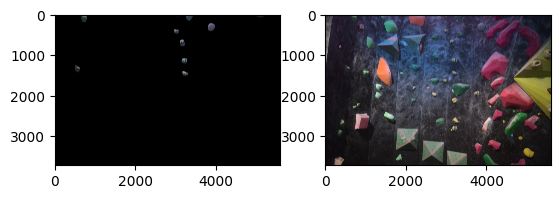

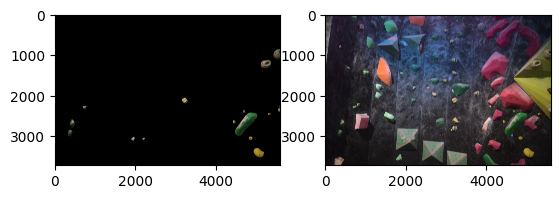

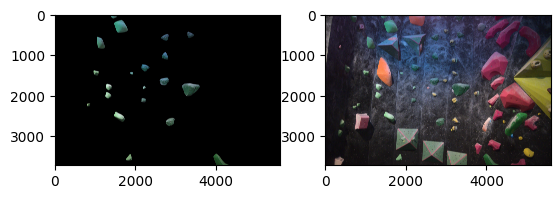

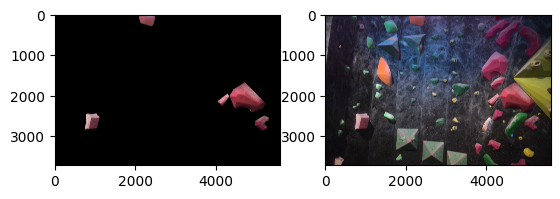

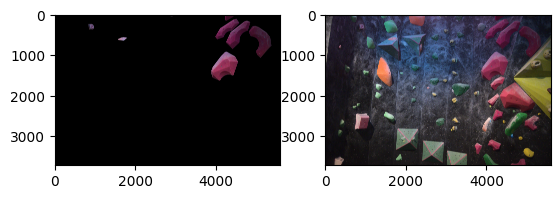

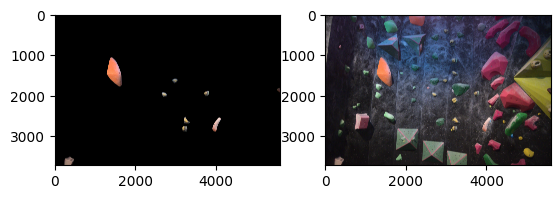

In [9]:
clustering_input = color_moments_arr_norm  # color_moment_arr
km_moments = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_moments.fit_predict(clustering_input)

routes = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_moments.labels_):
    routes[cluster].append(id)

plot_routes(routes, d_dict)

# Histogram

In [10]:
histograms = defaultdict(list)
for idx, poly in enumerate(d_dict["annotations"]):
    if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
        continue
    points = np.array(poly["segmentation"])
    points = points.reshape((-1, 2)).astype(np.int32)
    points = points[np.newaxis, :]
    mask = cv2.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
    hist0 = cv2.calcHist([image], [0], mask=mask, histSize=[256], ranges=[0, 256])
    hist1 = cv2.calcHist([image], [1], mask=mask, histSize=[256], ranges=[0, 256])
    hist2 = cv2.calcHist([image], [2], mask=mask, histSize=[256], ranges=[0, 256])
    hist = np.array([hist0])
    histograms[idx] = hist.flatten()

In [11]:
histograms_arr = np.array(list(histograms.values()))
histograms_arr_norm = histograms_arr - np.mean(histograms_arr, axis=0)
histograms_arr_norm = np.nan_to_num(
    histograms_arr_norm / np.std(histograms_arr_norm, axis=0)
)

/tmp/ipykernel_41805/4206031349.py:3: RuntimeWarning: invalid value encountered in divide
  histograms_arr_norm = np.nan_to_num(histograms_arr_norm / np.std(histograms_arr_norm, axis=0))


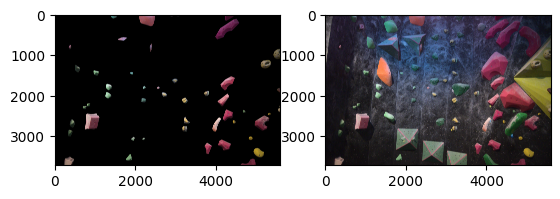

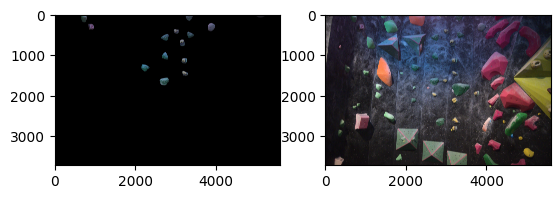

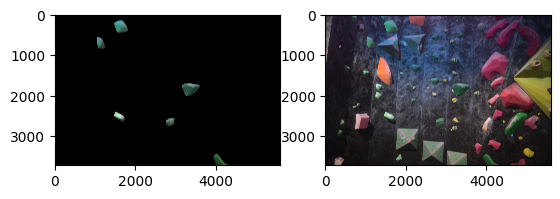

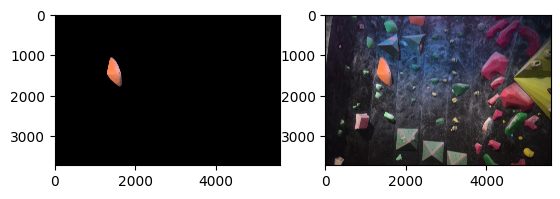

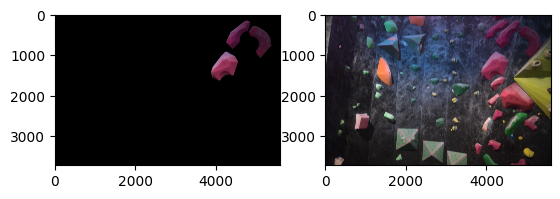

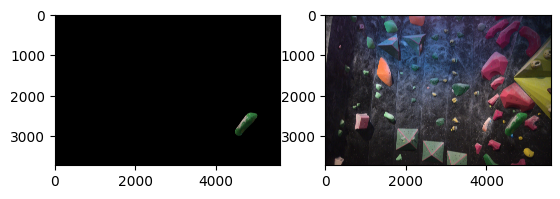

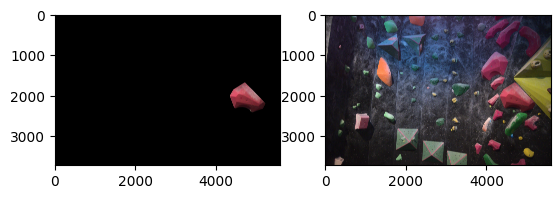

In [12]:
clustering_input = histograms_arr_norm  # histograms_arr
km_histogram = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_histogram.fit_predict(clustering_input)

routes = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_histogram.labels_):
    routes[cluster].append(id)

plot_routes(routes, d_dict)